# Формулировка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе своего анализа вы должны:

Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
А также ответить на ключевые вопросы HR-агентства:
Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

## Загрузка тебуемых библиотек

In [360]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 


Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:

Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
А также ответить на ключевые вопросы HR-агентства:
Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

# 1.Загрузка и обработка данных

In [361]:

#data = pd.read_csv("C:\Data_sets\ds_salaries.csv")

In [362]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [363]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений). Числовые признаки - unnmed, salary, salary_in_usd. Год работы -категориальный признак, считаю, ему некорректно быть int.Remote_ratio -представляют собой категории (отсутствие удаленной работы, частичная удаленная работа и полная удаленная работа), мы преобразуем его тоже в категориальный признак, чтобы использовать для категориального анализа.

In [364]:
data['work_year'] = data['work_year'].astype('category')
data['remote_ratio'] = data['remote_ratio'].astype('category')

Посмотрим на корреляции числовых признаков. Убираем unnmaed, salary. И заодно уже с ними валюту зарплаты. Оставим только salary_in_usd. В принципе, все это видно итак, но в данном учебном проекте для наглядности.

<Axes: >

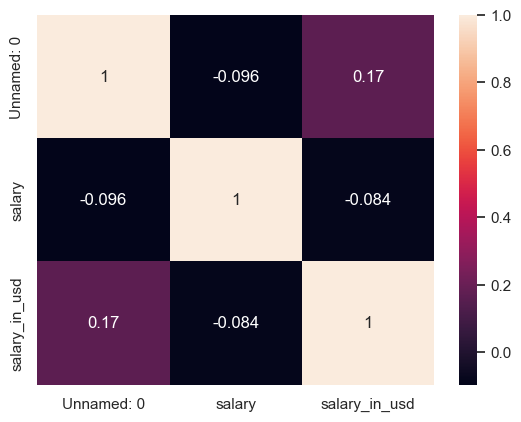

In [335]:
import seaborn as sns

# отсеиваем числовые признаки и включаем отображение коэффициентов
sns.heatmap(data.corr(numeric_only=True), annot=True)

In [365]:
data2 = data.copy() # на всякий случай копируем исходный датасет
data.drop(columns=(['salary_currency','salary','Unnamed: 0','salary_currency']), inplace=True)

Проверим данные на наличие полных дубликатов:

In [366]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))


Количество дубликатов: 42


Поскольку речь в ТЗ идет о двух профессиях Data Scientist и Data Engineer, сделаем выборку по двум профессиям и будем далее работать с получившимся датасетом датасетом.

In [367]:
# подготовка данных о DS и DE
data_s = data[data['job_title'] == 'Data Scientist']
data_se = data[(data['job_title'] == 'Data Scientist') | (data['job_title'] == 'Data Engineer')]
data_e = data[data['job_title'] == 'Data Engineer']


## Распределение заработной платы

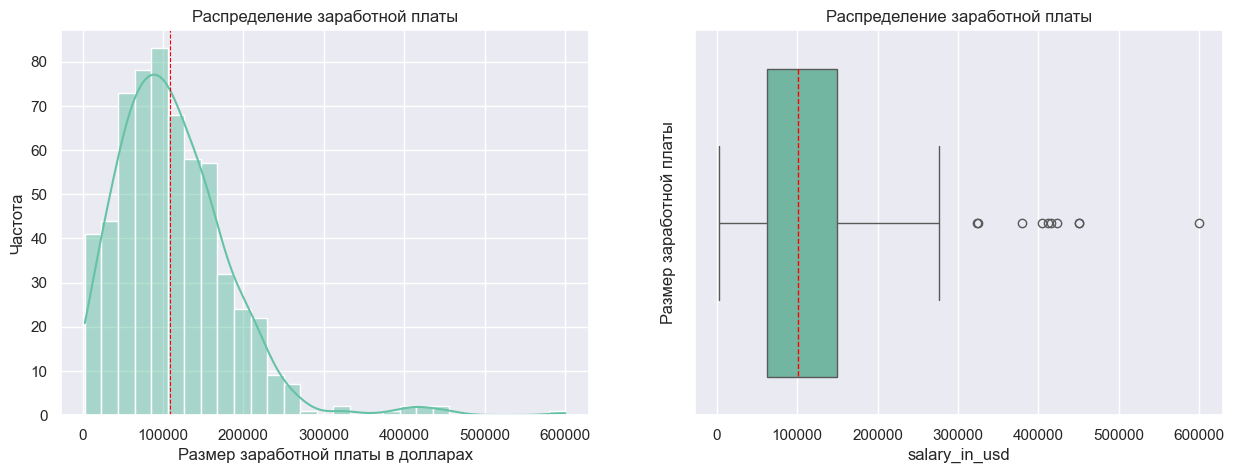

In [353]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы в долларах', ylabel='Частота')
axes[0].set_title('Распределение заработной платы')
axes[0].axvline(data_s['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы')

plt.show()

Точки не располагаются на диагонали — распределение заработной платы не является нормальным (как мы видели и по гистограмме).

In [368]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 




# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data['salary_in_usd'])

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

# p-value = 0.015
# Распределение не нормальное

p-value = 0.000
Распределение не нормальное


In [356]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Заработная плата в долларах']
data_agg

,Заработная плата в долларах
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


**Вывод. Распределение признака заработной платы не выглядит как нормальное. Среднее и медиана не совпадают.**

In [357]:
# Удаление стобцов с дублироующейся информацией
data2 = data.copy()
#data.drop(columns=['Unnamed: 0'], inplace=True) # удаляем ненужный столбец
# удаляем столбцы заработной платы в родной валюте и саму валюту, поскольку это дублирующиеся признаки
data_s.drop(columns=(['salary_currency','salary']), inplace=True)


Из таблицы корреляций видно, что можно смело удалять колнку unnamed, зарплату. Это, в принципе итак было видно 'на глаз'. 

# 1.Размер заработной платы DS зависимости от года работы

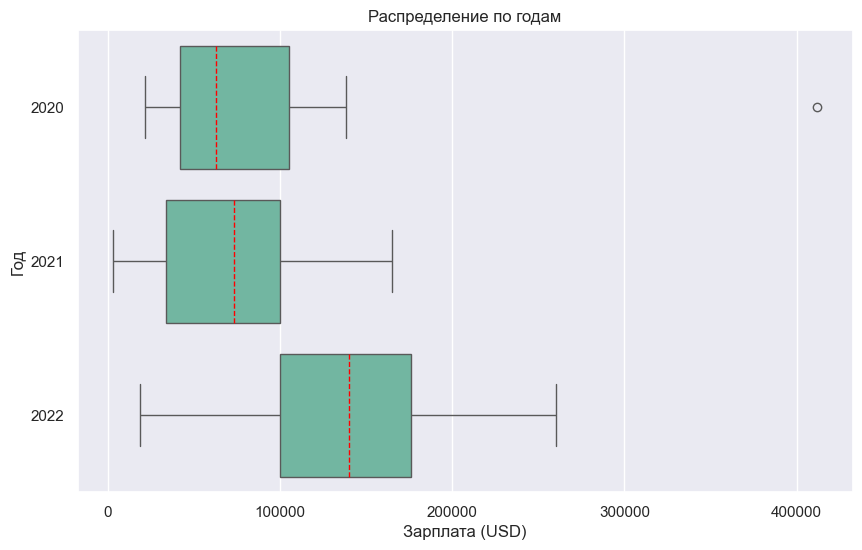

In [369]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
# взяли датасет data_s
ax = sns.boxplot(data=data_s, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата (USD)', ylabel='Год')
plt.title('Распределение по годам')
plt.show()


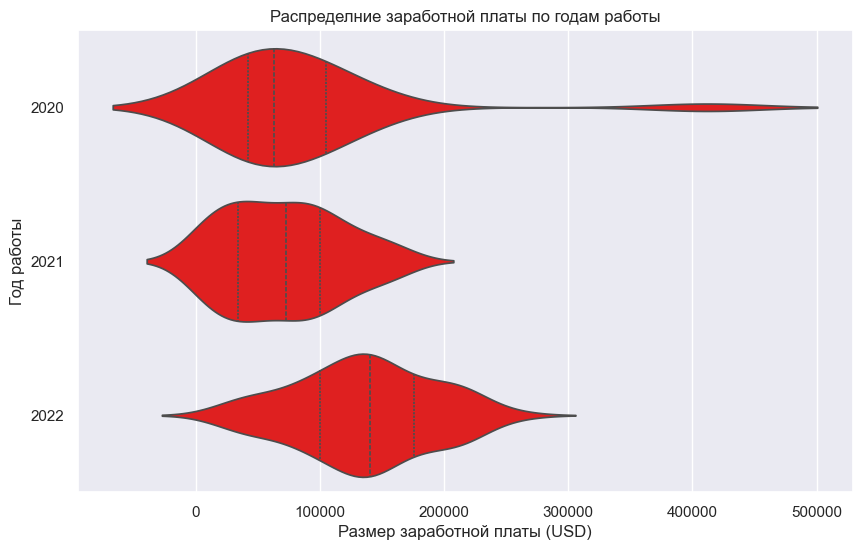

In [370]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Создание виолончельного графика с красным цветом
ax = sns.violinplot(data=data_s, x='salary_in_usd', y='work_year', orient='h', inner='quartile', color='red')
ax.set(xlabel='Размер заработной платы (USD)', ylabel='Год работы')
plt.title('Распределние заработной платы по годам работы')
plt.show()


**Распределение заработной платы по годам отличаются. Интересно их различие на вайолин плот. Так в 2020 году виалончель довольно вытянутая, правильной формы. в 2021 году она имеет два пика - на низкой заработной плате и на более высокой, чуть выше медианы. В 2022 году она становится более правильной, но единственная выпуклость уже выше медианы.**

In [371]:
data_agg = data_s.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение по годам')
data_agg

Распределение по годам


C:\Users\DS\AppData\Local\Temp\ipykernel_10784\1861747505.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_agg = data_s.groupby('work_year')['salary_in_usd'].describe().round(2)


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


**На первый взгляд распределение заработной платы в зависимости от лет наглядно видно. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.Также отметим, что по количеству в 2020 году самих наблюдений критически мало. Заполнять его не особо уместно ( как правило заполняется не более 30%. Поскольку проект учебный я его оставляю. Но по факту следовало бы отбросить)**

**Чтобы понять являются ли эти различия статистически значимыми проведем статистические тесты**

In [372]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

## Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist??

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплат у специалистов Data Scientist во всех трех выборках не увеличивается ежегодно ($μ_1$)  ($μ_2$) ($μ_3$).

$$ H_0 : μ_1 >= μ_2>= μ_3$$

*Альтернативная гипотеза* ($H_1$): размер зарплат у специалистов Data Scientist во всех трех выборках увеличивается ежегодно ($μ_1$)  ($μ_2$) ($μ_3$)
.

$$ H_1 : μ_1 <μ_2< μ_32$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [373]:
import pandas as pd
from scipy import stats


# Выводим зарплаты за 2020 2021 2022
charges_2020 = data_s.loc[data_s['work_year'] == 2020, 'salary_in_usd']
charges_2021 = data_s.loc[data_s['work_year'] == 2021, 'salary_in_usd']
charges_2022 = data_s.loc[data_s['work_year'] == 2022, 'salary_in_usd']

# Проводим тест Шапиро-Уилка для 2020 года
print('Для 2020:')
result_2020 = stats.shapiro(charges_2020)
print(decision_normality(result_2020[1]))

# Проводим тест Шапиро-Уилка для 2021 года
print('Для 2021:')
result_2021 = stats.shapiro(charges_2021)
print(decision_normality(result_2021[1]))

# Проводим тест Шапиро-Уилка для 2022 года
print('Для 2022:')
result_2022 = stats.shapiro(charges_2020)
print(decision_normality(result_2022[1]))

Для 2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
None
Для 2021:
p-value = 0.125
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
None
Для 2022:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
None


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата в USD»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать Краксела- Уоллиса.

**Проведём тест**

In [374]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 


# проводим тест
_, p = stats.kruskal(charges_2020, charges_2021, charges_2022)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


**Вывод - отвергаем нулевую гипотезу, заработные платы из года в год растут.**

# 2 . Признак заработной платы в контексте зарплат DS и DE в 2022 году

Проверим два признака 'Salary_in_usd' для DS и DE, соответственно.

In [375]:
# подготовим датасеты за 2022 годы
data_se_2022 = data_se[data_se['work_year']== 2022]
data_se_2022.loc[:, 'salary_in_usd'] = data_se_2022['salary_in_usd'].fillna(data_se_2022['salary_in_usd'].mean())
data_s_2022 = data_se_2022[data['job_title'] == 'Data Scientist']
data_e_2022 = data_se_2022[data['job_title'] == 'Data Engineer']
#data_s_2022=data_se[data_s['work_year']== 2022]
#data_e_2022=data_e[data_e['work_year']== 2022]
#data_s_2022.loc[:, 'salary_in_usd'] = data_s_2022['salary_in_usd'].fillna(data_s_2022['salary_in_usd'].median())
#data_e_2022.loc[:, 'salary_in_usd'] = data_e_2022['salary_in_usd'].fillna(data_e_2022['salary_in_usd'].median())



C:\Users\DS\AppData\Local\Temp\ipykernel_10784\3298201015.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_s_2022 = data_se_2022[data['job_title'] == 'Data Scientist']
C:\Users\DS\AppData\Local\Temp\ipykernel_10784\3298201015.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_e_2022 = data_se_2022[data['job_title'] == 'Data Engineer']


In [ ]:
data_se_2022

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
289,2022,SE,FT,Data Engineer,135000,US,100,US,M
292,2022,MI,FT,Data Scientist,130000,US,0,US,M
293,2022,MI,FT,Data Scientist,90000,US,0,US,M
294,2022,MI,FT,Data Engineer,170000,US,100,US,M
295,2022,MI,FT,Data Engineer,150000,US,100,US,M
...,...,...,...,...,...,...,...,...,...
596,2022,SE,FT,Data Scientist,210000,US,100,US,M
598,2022,MI,FT,Data Scientist,160000,US,100,US,M
599,2022,MI,FT,Data Scientist,130000,US,100,US,M
602,2022,SE,FT,Data Engineer,154000,US,100,US,M


Визуализируем DS

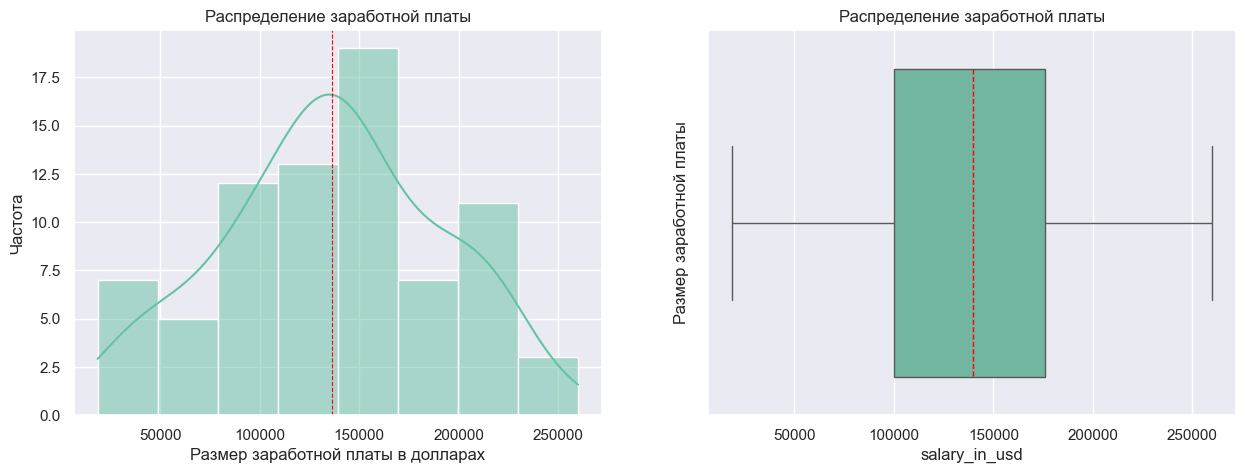

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_s_2022['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы в долларах', ylabel='Частота')
axes[0].set_title('Распределение заработной платы')
axes[0].axvline(data_s_2022['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data_s_2022['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы')

plt.show()

Распределение выглядит нормальным

Проверим его на нормальность при помощи Шапиро. 

In [ ]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

# загружаем данные
data_s1 = data_s_2022['salary_in_usd']

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_s1)

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.327
Распределение нормальное


In [ ]:
data_s_2022agg = data_s_2022['salary_in_usd'].describe().round(2).to_frame()
data_s_2022agg.columns = ['Заработная плата в долларах']
data_s_2022agg

,Заработная плата в долларах
count,77.00
mean,136172.09
std,54563.08
min,18442.00
25%,100000.00
50%,140000.00
75%,176000.00
max,260000.00


**Вывод. Распределение является нормальным.**

Сделаем то же самое для DE

In [ ]:
data_e_2022 = data_e_2022[data_e_2022['salary_in_usd'] <= 250000]

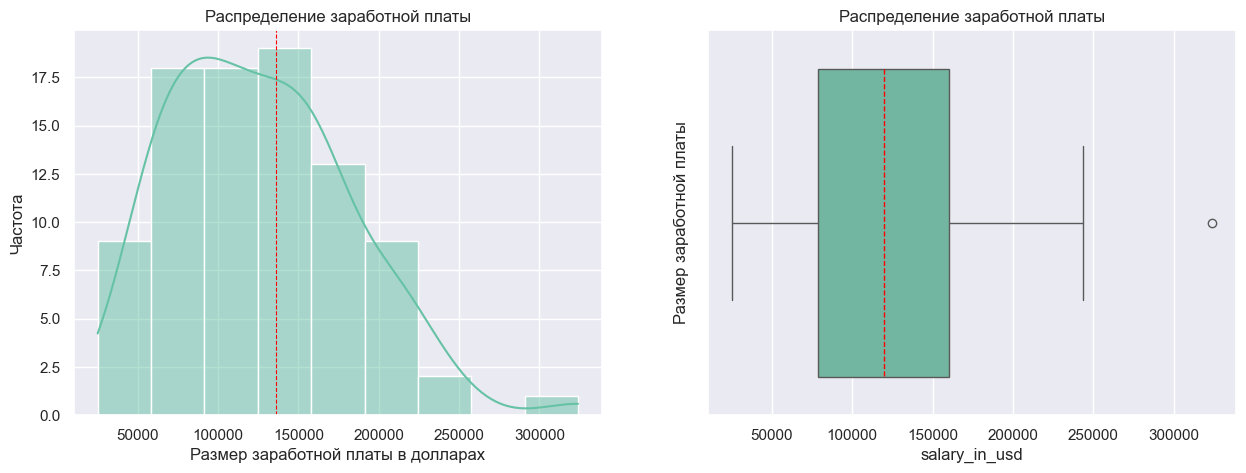

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data_e_2022['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер заработной платы в долларах', ylabel='Частота')
axes[0].set_title('Распределение заработной платы')
axes[0].axvline(data_s_2022['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data_e_2022['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер заработной платы')
axes[1].set_title('Распределение заработной платы')

plt.show()

In [ ]:
## данное условие создано в рамках очистки данных и удаления выбросов
data_e_2022 = data_e_2022[data_e_2022['salary_in_usd'] <= 250000]

In [ ]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

# загружаем данные
data_e1 = data_e_2022['salary_in_usd']

# проводим тест Шапиро — Уилка
_, p = stats.shapiro(data_e1)

print('p-value = %.3f' % (p))

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.035
Распределение не нормальное


In [ ]:
data_e_2022agg = data_e_2022['salary_in_usd'].describe().round(2).to_frame()
data_e_2022agg.columns = ['Заработная плата в долларах']
data_e_2022agg

,Заработная плата в долларах
count,88.00
mean,124129.97
std,52085.20
min,25000.00
25%,78526.00
50%,118894.50
75%,160000.00
max,243900.00


Вывод. Распределение нормальным не является.

Нулевая гипотеза. Уровень зарплат DE статистически не отличается от уровня зарплат DS
Альтернативная гипотеза.Уровень зарплат DS статистически отличается от уровня зарплат DE

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата DS/DE в USD»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет(один - да. Но один нет).

Чтобы проверить нашу гипотезу, можно использовать Критрей Манна- Уитни

**Проведём тест**

In [ ]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

data_s_2022_d = data_s_2022['salary_in_usd'].to_list()
data_e_2022_d = data_e_2022['salary_in_usd'].to_list()


# проводим тест
_, p = stats.mannwhitneyu(data_e_2022['salary_in_usd'],data_s_2022['salary_in_usd'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))



p-value = 0.118
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


***Как и графики, которые очень похожи,  статистический тест показывает, что значения увеличения ПОЧТИ не значимы. Но коэффициент p-value очень близок к пороговому значению. Делаем вывод, что рост все-таки статистически значим**

## 3. Зарплаты специалистов Data Scientist в компаниях различных размеров.

Посмотрим на распределение категориального признака "размер компании'.


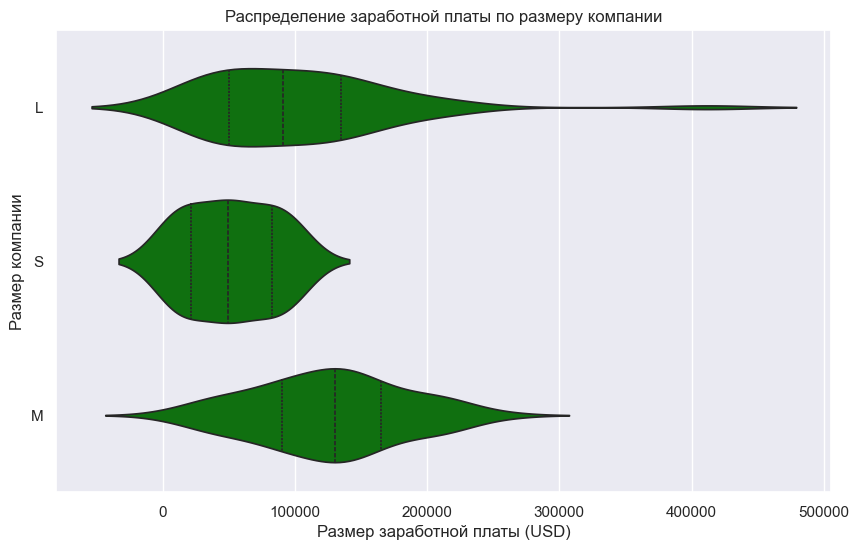

In [406]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Создание виолончельного графика с красным цветом
ax = sns.violinplot(data=data_s, x='salary_in_usd', y='company_size', orient='h', inner='quartile', color='green')
ax.set(xlabel='Размер заработной платы (USD)', ylabel='Размер компании')
plt.title('Распределение заработной платы по размеру компании')
plt.show()


Из графика видно различие заработной платы в заисимости от размера компании. Наибольшие зарплаты у DS  компаниях размера M. Также видно, что плотность заработных плат для компаний размера S наименьшая и" не растянута". Зарплаты здесь сконцентрированы в определеном плотном промежутке.

In [407]:
grouped_stats = data_s1.groupby('company_size')
grouped_stats.describe().round(2)

salary_in_usd                                                   \
                     count       mean       std      min      25%       50%   
company_size                                                                  
1                     21.0   51925.76  33216.29   2859.0  21669.0   49268.0   
2                     77.0  126380.75  56389.53   4000.0  90000.0  130000.0   
3                     45.0  103313.36  71815.18  13400.0  50000.0   90734.0   

                                  
                   75%       max  
company_size                      
1              82500.0  105000.0  
2             165000.0  260000.0  
3             135000.0  412000.0

**Компании размера S следует исключить из выборки. Данных критически мало.**

In [378]:
data_s1 = data_s.copy()
data_s1['company_size'] = data_s1['company_size'].replace(["S", "M", "L"], [1, 2, 3])


# приготовили выборкb
#data_ss = data_s1[data_s1['company_size'] == 1]['salary_in_usd'].to_list()
data_sm = data_s1[data_s1['company_size'] == 2]['salary_in_usd'].to_list()
data_sl = data_s1[data_s1['company_size'] == 3]['salary_in_usd'].to_list()


Missing values in 'S': 0
Missing values in 'M': 0
Missing values in 'L': 0


C:\Users\DS\AppData\Local\Temp\ipykernel_10784\1242746616.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_s1['company_size'] = data_s1['company_size'].replace(["S", "M", "L"], [1, 2, 3])


Приготовим наши выборки.Нулевая гипотеза - данные в компаниях размера M и L не различаются. Альтернативная гипотеза - различие имеется и оно статистически - значимо.

In [408]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

# загружаем данные

# проводим тест
_, p = stats.kruskal(data_sm, data_sl,data_sm)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))



p-value = 0.019
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Проверка двух выборок критерием Манна-Уитни. Нулевая гипотеза -  в компаниях M зарплата e DS больше, чем в L. Альтернативная гипотеза - в компаниях L больше или равна зарплате в компаниях M.

In [411]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 


# проводим тест (Mann-Whitney U-test)
_, p = stats.mannwhitneyu(data_sl, data_sm, alternative='greater')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу. Зарплата в компаниях размера "L" значительно больше, чем в компаниях размера "M".'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу. Нет достаточных оснований утверждать, что зарплата в компаниях размера "L" значительно больше, чем в компаниях размера "M".'.format(alpha))


p-value = 0.994
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу. Нет достаточных оснований утверждать, что зарплата в компаниях размера "L" значительно больше, чем в компаниях размера "M".


**Итак мы выяснили, что заработные платы в различных по размеру компаниях отличаются. В компаниях M она больше чем в компаниях L.**

In [ ]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

# загружаем данные (предполагается, что data_sl and data_sm are already defined)

# проводим тест (Mann-Whitney U-test)
_, p = stats.mannwhitneyu(data_ss, data_sm, alternative='less')

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу. Зарплата в компаниях размера "M" значительно больше, чем в компаниях размера "S".'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу. Нет достаточных оснований утверждать, что зарплата в компаниях размера "M" значительно больше, чем в компаниях размера "S".'.format(alpha))


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу. Зарплата в компаниях размера "M" значительно больше, чем в компаниях размера "S".


**Вывод. Действительно, то, что мы видели в визуализации, подтвердилось. l<M. Существуют статистически значимые различия в заработных платах согласно разного размера компаний.**

## 4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


In [393]:
# Создадим признак для обозначения отсутствия/наличия должностей в той или иной компании
data['is_DS_DE'] = data['job_title'].apply(lambda x: 1 if x == 'Data Scientist' or x == 'Data Engineer' else 0)
new_data = data.groupby('is_DS_DE')['company_size']


Продемонстрируем наглядно распределение наличия/отсутствия должностей

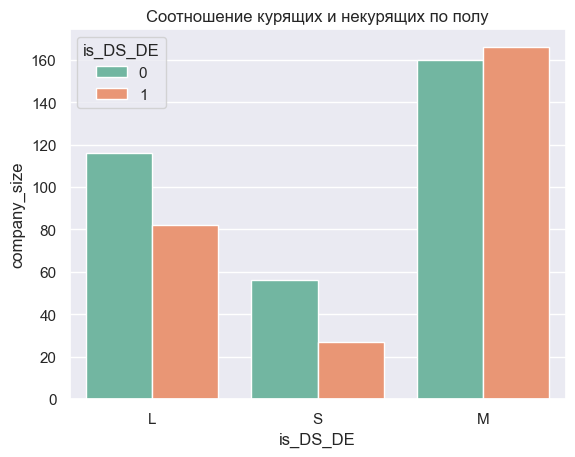

In [399]:
ax = sns.countplot(data=data, x=data['company_size'], hue='is_DS_DE')
ax.set(xlabel='is_DS_DE', ylabel='company_size')
plt.title('Соотношение наличия/отсутствия должностей DS/DE')
plt.show()

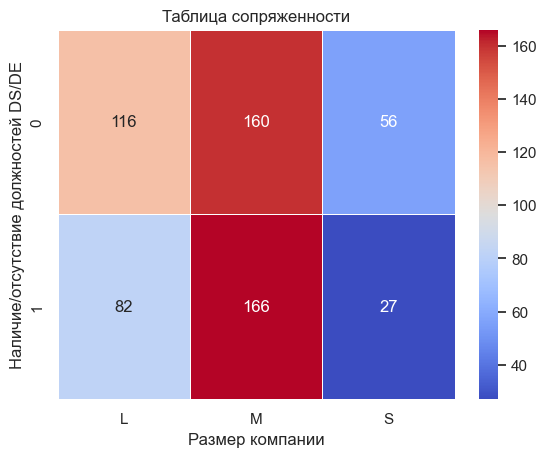

In [405]:
ax = sns.heatmap(table, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Наличие/отсутствие должностей DS/DE')
plt.title('Таблица сопряженности')
plt.show()

Запрос ТЗ заключался в ответе на вопрос есть ли статистически- значимая связь между величиной компании и наличием должностей DS или DE. Оба признака являются категориальными. Для анализа воспользуемся методом кси-квадрат.

Нулевая гипотеза - данные должности не взаимосвязаны. Альтернативная- присутствует связь.

In [392]:
import scipy.stats as stats
import pandas as pd

# задаём уровень значимости
alpha = 0.05 



# вычисляем таблицу сопряжённости
table = pd.crosstab(data['is_DS_DE'], data['company_size'])

# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# p-value = 0.373
# p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

p-value = 0.004
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Итак, между наличием должностей DS и DE присутствует статистически-значимая связь.

## Итоговые результаты исследования

*   В контексте 2020-2022 у DS наблюдается рост зарплат. За 2020 год данных критически мало. Заполнять нецелесообразно. 
*   Зарплаты DS и DE почти не различаются статистически. Но уровень p - value практически пороговый. Делаем вывод, что зарплата DS статистически несколько больше зарплаты DE
*   Есть статистически-значимые различия в зарплате DS в зависимости от размера компании. Зарплата в компании M больше, чем зарплата в компаниях L. Для компаний S критически мало данных. Они отброшены.
*   Существует взаимосвязь наличием должностей DS и DE и размером компании.
